In [1]:
# go wide screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# This version implements a 
# spectrally variing detection threshold.
import time
import numpy as np
import spectrum
from collections import OrderedDict
import argparse
from astropy.io import fits
from astropy import wcs
import sys
from astropy.io import ascii
import os

import numpy as np
#from imageio import imread
from matplotlib import pyplot as plt
%matplotlib inline

import maxflow

In [3]:
def pp(s):
    print(s)
    return s + "\n"


def grow_segment(c, outmap, x, y, z, threshold, label):
    # Non object oriented version
    def get_children(zyx, shape):
        maxz, maxy, maxx = shape
        z, y, x = zyx
        children = []
        ddx = [-1,0,1]
        ddy = [-1,0,1]
        ddz = [-1,0,1]
        #ddz = [0]
        for dx in ddx:
            for dy in ddy:
                for dz in ddz:
                    if not dx == dy == dz == 0:
                        newx, newy, newz = x+dx, y+dy, z+dz
                        if newx >= 0 and newx < maxx\
                            and newy >= 0 and newy < maxy\
                            and newz >= 0 and newz < maxz:
                               children.append( (newz, newy, newx) ) 
        return children

    pixel_list = []
    stack = [(z,y,x)]
    outmap[(z,y,x)] = label

    maxiter = 1e6
    iter = 0
    while len(stack) > 0: 
        pm = stack.pop()
        pp = get_children(pm, c.shape)
        for p in pp:
            if c[p] >= threshold and  outmap[p] == 0: # pixel that are labeled 0 have not been visited yet
                stack.append(p)
                outmap[p] = label
            elif c[p] < threshold and  outmap[p] == 0:
                outmap[p] = -1 # label pixel with -1 if they have beed visited already
        iter += 1
        if iter > maxiter:
            break

    return outmap#pixel_list            


def build_map(ww, c, sigma_detect_threshold, sigma_grow_threshold, noise_model):
    # run cloud growth algorithm on all pixels above detection threshold
    # try to be intelligent, only loop over pixels that exceed detection threshold
    ii = (c.swapaxes(2,0) > np.polyval(noise_model, ww) * sigma_detect_threshold ).swapaxes(2,0)
    
    
    N =  (np.sum(ii))
    print("{} pixel above detection threshold".format(N))

    outmap = np.zeros_like(c, dtype=int)

    zz,yy,xx = [np.arange(s, dtype=int) for s in c.shape]
    YY,ZZ,XX = np.meshgrid(yy, zz, xx)

    label = 1
    for i, (x,y,z) in enumerate( zip(XX[ii], YY[ii], ZZ[ii] ) )  :  
        if outmap[z,y,x] == 0:
            pp("### {} z={} ###".format(i,z))
            print(x,y,z, outmap[z,y,x])
            #outmap = build_map2(c, outmap, x,y,z, threshold = grow_threshold, label=label)

            summary = ""
            summary += pp("Building map starting with pixel {} out of {} that exceeds threshold...".format(i,N))
            start_time = time.time()
            #print("{} labeled pixels on map".format( np.nansum( (outmap > 0).flatten())) )
            
            # Here we set to which threshold a region shoudl be grown.
            # note that this is not stricly correct, the threshold should very also inside
            # grow_segment as function of wavelength. Here we will just rely on this
            # being a slowly variing function.
            threshold = np.polyval(noise_model, ww[z]) * sigma_grow_threshold
            print("grow_threshold = ", threshold)
            outmap = grow_segment(c, outmap, x,y,z, threshold, label=label)
            time_to_build = time.time() - start_time
            summary += pp("Time to build map: {:.4e} s".format(time_to_build))

            print("{} labeled pixels on map".format( np.nansum( (outmap > 0).flatten())) )
            print("{} untouched pixels on map".format( np.nansum( (outmap == 0).flatten())) )

        label += 1

        if i > 1e6:
            break
    #print (cnt)
    return outmap


def filter_minsize(outmap, minsize):
    # filter regions with too small volume 
    rr = np.sort( np.unique( outmap.flatten() ) )
    for r in rr:
        if not r > 0:
            continue
        N = np.sum( outmap == r )
        #print("{} : N = {}".format(r, N))
        if N < minsize:
            outmap[outmap == r] = -1  
    rr = np.sort( np.unique( outmap.flatten() ) )
    
    # relabel
    for i,r in enumerate(rr[rr>0]):
        outmap[outmap == r] = i + 1

    rr = np.sort( np.unique( outmap.flatten() ) )
    print("{} regions survive size cut".format( len(rr[rr>0]) ))

    return outmap



def save_map(outmap, fmapout):
    w = wcs.WCS(s.hdu)
    # save map
    f = np.zeros_like(c)
    f[outmap > 0] = c[outmap > 0]
    wcs_header =  w.to_header()


    h = fits.PrimaryHDU(data=outmap, header=s.hdu.header)
    for k in wcs_header:
        h.header[k] = wcs_header[k]
    hdu = fits.HDUList(h)

    # save map filtered data
    f = np.zeros_like(c)
    f[outmap > 0] = c[outmap > 0]
    h = fits.ImageHDU(data=f, header=s.hdu.header, name = "filtered_data")
    for k in wcs_header:
        h.header[k] = wcs_header[k]

    hdu.append(h)

    # save shells 
    f = np.zeros_like(c)
    f[outmap == -1] = c[outmap == -1]

    h = fits.ImageHDU(data=f, header=s.hdu.header, name = "shells")
    for k in wcs_header:
        h.header[k] = wcs_header[k]
    hdu.append(h)

    hdu.writeto(fmapout, overwrite=True)
    print("Wrote {}.".format(fmapout))

 

# netflow example

In [11]:
from scipy.misc import imread
img = imread("hetdex.png")[:,:,0]
img = img/img.max()
img = img + np.random.normal(size=img.shape)*1.
f = plt.figure(figsize=[10,10])
plt.imshow(img, cmap=plt.cm.gray)



/home1/04287/mxhf/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


FileNotFoundError: [Errno 2] No such file or directory: 'hetdex.png'

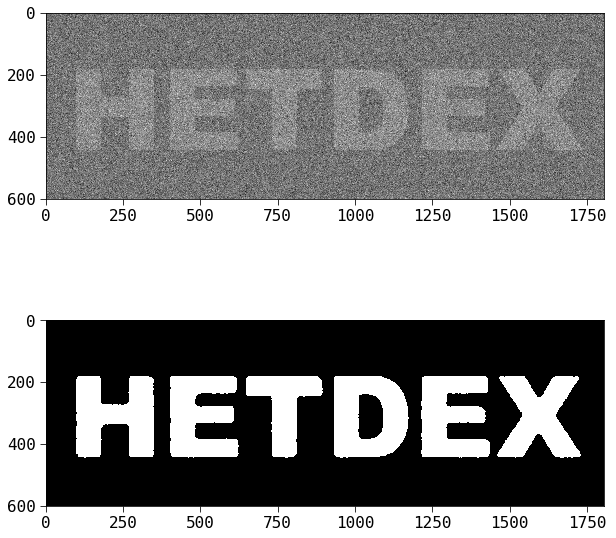

In [91]:
# Create the graph.
g = maxflow.Graph[float](0, 0)
# Add the nodes.
nodeids = g.add_grid_nodes(img.shape)

structure = np.array([[1, 1, 1],
                      [1, 0, 1],
                      [1, 1, 1]])

# Add edges with the same capacities.
g.add_grid_edges(nodeids, 1.1, structure=structure)
# Add the terminal edges.
g.add_grid_tedges(nodeids, np.abs((img)), np.abs(1.-(img)) )

# Find the maximum flow.
g.maxflow()
# Get the segments.
sgm = g.get_grid_segments(nodeids)

# The labels should be 1 where sgm is False and 0 otherwise.
img2 = np.int_(np.logical_not(sgm))
# Show the result.

f = plt.figure(figsize=[10,10])
plt.subplot(211)
plt.imshow(img, cmap=plt.cm.gray, interpolation='nearest')
plt.subplot(212)
plt.imshow(img2, cmap=plt.cm.gray, interpolation='nearest')

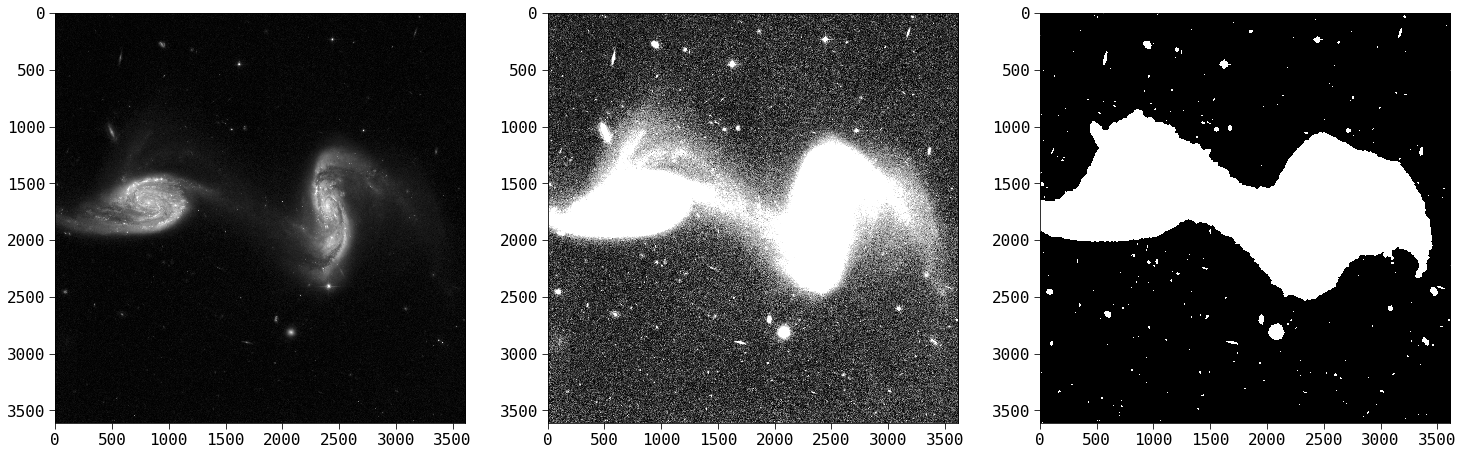

In [87]:
from scipy.misc import imread
img = imread("gals.png")[:,:,0]
f = plt.figure(figsize=[10,10])
#plt.imshow(img, cmap=plt.cm.gray)

# Create the graph.
g = maxflow.Graph[float](0, 0)
# Add the nodes.
nodeids = g.add_grid_nodes(img.shape)

structure = np.array([[1, 1, 1],
                      [1, 0, 1],
                      [1, 1, 1]])

# Add edges with the same capacities.
g.add_grid_edges(nodeids, 10., structure=structure)
# Add the terminal edges.
g.add_grid_tedges(nodeids, np.abs((img)), np.abs(30.-(img)) )

# Find the maximum flow.
g.maxflow()
# Get the segments.
sgm = g.get_grid_segments(nodeids)

# The labels should be 1 where sgm is False and 0 otherwise.
img2 = np.int_(np.logical_not(sgm))
# Show the result.

f = plt.figure(figsize=[25,10])
plt.subplot(131)
plt.imshow(img, cmap=plt.cm.gray, interpolation='nearest')
plt.subplot(132)
plt.imshow(img, cmap=plt.cm.gray, interpolation='nearest', vmin=0,vmax=30)
plt.subplot(133)
plt.imshow(img2, cmap=plt.cm.gray, interpolation='nearest')

## This is a first example for image segmentation by netflow 
Here pixel value differences are not taken into account.

In [9]:
workdir = "/work/04287/mxhf/maverick/hetdex/cubes"
datadir = os.path.join(workdir, "data")

fcube = "sf2outcube_COSMOSA_022.fits.gz"
fnoisemodel = "sf2ncoutcube_COSMOSA_022.noisemodelw"

In [10]:
s = spectrum.readSpectrum(os.path.join(datadir, fcube))
ww = s.grid()
c = s.data

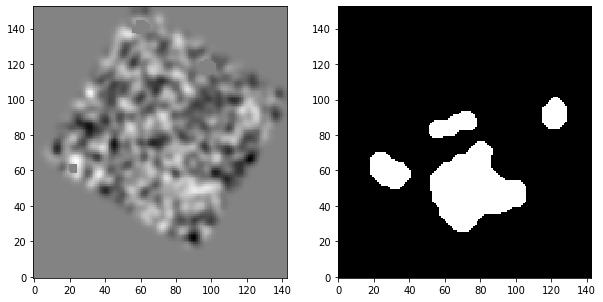

In [11]:
img = np.sum( c[117:126], axis=0 )*6.

# Create the graph.
g = maxflow.Graph[float](0, 0)
# Add the nodes.
nodeids = g.add_grid_nodes(img.shape)

structure = np.array([[1, 1, 1],
                      [1, 0, 1],
                      [1, 1, 1]])

# Add edges with the same capacities.
g.add_grid_edges(nodeids, 9., structure=structure)
# Add the terminal edges.
g.add_grid_tedges(nodeids, img, 1.-img)

# Find the maximum flow.
g.maxflow()
# Get the segments.
sgm = g.get_grid_segments(nodeids)

# The labels should be 1 where sgm is False and 0 otherwise.
img2 = np.int_(np.logical_not(sgm))
# Show the result.

f = plt.figure(figsize=[10,10])
plt.subplot(121)
plt.imshow(img, cmap=plt.cm.gray, interpolation='nearest', origin="bottom")
plt.subplot(122)
plt.imshow(img2, cmap=plt.cm.gray, interpolation='nearest', origin="bottom")

# Now try in 3D

In [17]:
# Build a datacue with an object in it.
c = np.zeros([5,5,5], dtype=float)
c[1,2:3,2:3] = 1.
c[2,1:4,1:4] = 1.
c[3,2:3,2:3] = 1.

In [18]:
import numpy as np
import sys
from matplotlib import pyplot as plt

import maxflow

s = spectrum.readSpectrum(os.path.join(datadir, fcube))
ww = s.grid()

In [19]:
w_spatial = .015
w_z = 10.
w_color = .015

dscale = 30.
c = np.array([25. * np.mean( s.data[117:126], axis=0 )])
c = dscale * s.data[118-2:118+3]

dscale = 20.
#c = dscale * s.data[116:121] # small testslice on diffuse structure after PCA
#c = dscale * s.data[114:128]
#c = dscale * s.data[90:150] # 60 slices
#c = dscale * s.data # whloe cube (breaks)

dscale = 16.
#c = dscale * s.data[176-20:176+20] # HDLAB1
#c = dscale * s.data[178-4:178+4] # HDLAB1



# Create a graph with integer capacities.
# beust guesse for number of nodes and edges
nnodes = len( c.flatten() )
nedges = len( c.flatten() )*26 + 2*len( c.flatten() )
g = maxflow.Graph[float](nnodes, nedges )
# Add two (non-terminal) nodes. Get the index to the first one.
nodes = g.add_nodes(c.shape[0]*c.shape[1]*c.shape[2])

# store the node ids as cube
cnid = nodes.reshape(c.shape)

zlink = [0]
zlink = [-1,0,1]

ww = []
for z in range(c.shape[0]):
    print("Adding edges for slice {} of {}...".format(z,c.shape[0]))
    for y in range(c.shape[1]):
        for x in range(c.shape[2]):
            for dx in [-1,0,1]:
                for dy in [-1,0,1]:
#                    for dz in [0]:
                    for dz in zlink:
                        if dx == 0 and dy == 0 and dz == 0:
                            continue
                        if     x+dx >= 0 and x+dx < c.shape[2]\
                           and y+dy >= 0 and y+dy < c.shape[1]\
                           and z+dz >= 0 and z+dz < c.shape[0]:
                            
                            # compute difference in color space (= pixel values)
                            dc = np.abs(c[z,y,x] - c[z+dz,y+dy,x+dx])
                            
                            
                            w = 1./np.sqrt( w_spatial * dx**2. + w_spatial*dy**2. + w_z*dz**2. + w_color*dc**2.)
                            if w > 1e5:
                                1/0
                            
                            ww.append(w)
                            g.add_edge(cnid[z,y,x], cnid[z+dz,y+dy,x+dx], w, 0)
                            
g.add_grid_tedges(nodes, c.flatten(), 1.-c.flatten())

# Find the maximum flow.
g.maxflow()
# Get the segments.
sgm = g.get_grid_segments(nodes)

# The labels should be 1 where sgm is False and 0 otherwise.
img2 = np.int_(np.logical_not(sgm))
# Show the result.
cout = img2.reshape(c.shape)

Adding edges for slice 0 of 5...
Adding edges for slice 1 of 5...
Adding edges for slice 2 of 5...
Adding edges for slice 3 of 5...
Adding edges for slice 4 of 5...


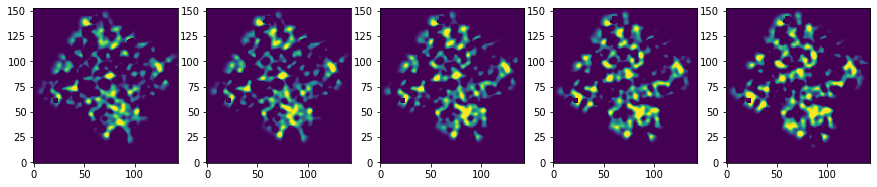

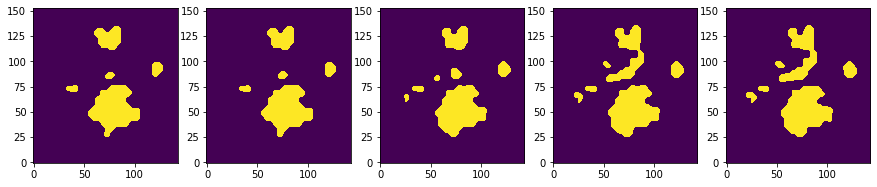

In [20]:
f = plt.figure(figsize=[15,10])
N = c.shape[0]
for i in range(N):
    plt.subplot(1,N,i+1)
    plt.imshow(c[i]/dscale, origin='bottom', interpolation='none',vmin=0., vmax=.3)

f = plt.figure(figsize=[15,10])
N = cout.shape[0]
for i in range(N):
    plt.subplot(1,N,i+1)
    plt.imshow(cout[i], origin='bottom', interpolation='none',)

In [11]:
h = s.hdu
h.data = cout
h.writeto("cout.fits", overwrite=True)

In [12]:
!pwd

/Users/mxhf/ownCloudRZG/work/MPE/hetdex/src/deep_and_repeat/COSMOS/src


In [15]:
s.data.shape[0]

1010

## fast graph construction, no color or distance based weights

In [13]:
import numpy as np
import sys
from matplotlib import pyplot as plt
%matplotlib inline

import maxflow

In [14]:
fcube = "sf2outcube_COSMOSA_022_pca.fits.gz"
fnoisemodel = "sf2outcube_COSMOSC_022_pca.detect_noise_model"
workdir = "/work/04287/mxhf/maverick/hetdex/cubes"
datadir = os.path.join(workdir, "data")

w = 9.
wz = .1

dscale = 5.
thickness = 10


In [15]:
# read data
s = spectrum.readSpectrum(os.path.join(datadir, fcube))
ww = s.grid()

# read noise model
noise_model = np.loadtxt(os.path.join(datadir, fnoisemodel) )

# scale date by noise
c = s.data
c = dscale* np.multiply(c.T, 1./np.polyval(noise_model, ww )).T

In [ ]:
# Create a graph with integer capacities.
# best guess for number of nodes and edges
nnodes = len( c.flatten() )
nedges = len( c.flatten() )*26 + 2*len( c.flatten() )
g = maxflow.Graph[float](nnodes, nedges )

nodes = g.add_grid_nodes(c.shape)

# connection weights based on Euclidian distances
structure = np.array([ w*wz* np.array([[.58, .7, .58],
                        [.7, 1, .7],
                        [.58, .7, .58]]),
                       w*np.array([[.7, 1, .7],
                        [1, 0, 1],
                        [.7, 1, .7]]),
                       w*wz*np.array([[.58, .7, .58],
                        [.7, 1, .7],
                        [.58, .7, .58]]) ])

g.add_grid_edges(nodes, structure=structure)
g.add_grid_tedges(nodes, c, 1.-c)

In [ ]:
# Find the maximum flow.
g.maxflow()

# Get the segments.
sgm = g.get_grid_segments(nodes)

# The labels should be 1 where sgm is False and 0 otherwise.
img2 = np.int_(np.logical_not(sgm))
# Show the result.
cout = img2.reshape(c.shape)

In [ ]:
N = c.shape[0]
if N < 15:
    f = plt.figure(figsize=[15,10])
    for i in range(N):
        plt.subplot(1,N,i+1)
        plt.imshow(c[i]/dscale, origin='bottom', interpolation='none',vmin=0., vmax=2.)

    f = plt.figure(figsize=[15,10])
    for i in range(N):
        plt.subplot(1,N,i+1)
        plt.imshow(cout[i], origin='bottom', interpolation='none')
plt.show()

In [ ]:
h = s.hdu
h.data = cout
h.writeto("cout.fits", overwrite=True)

## first fiddeling with pymaxflow

In [4]:
import maxflow

# Create a graph with integer capacities.
g = maxflow.Graph[int](2, 2)
# Add two (non-terminal) nodes. Get the index to the first one.
nodes = g.add_nodes(2)
# Create two edges (forwards and backwards) with the given capacities.
# The indices of the nodes are always consecutive.
g.add_edge(nodes[0], nodes[1], 1, 2)
# Set the capacities of the terminal edges...
# ...for the first node.
g.add_tedge(nodes[0], 2, 5)
# ...for the second node.
g.add_tedge(nodes[1], 9, 4)
g.maxflow()

8

In [5]:
print ("Segment of the node 0:", g.get_segment(nodes[0]))
print ("Segment of the node 1:", g.get_segment(nodes[1]))

Segment of the node 0: 1
Segment of the node 1: 0


In [6]:
# Create the graph.
g = maxflow.Graph[int](0, 0)
# Add the nodes.
nodeids = g.add_grid_nodes([2,2])
# Add edges with the same capacities.
g.add_grid_edges(nodeids, 25)

In [7]:
g.get_edge_count()

16

8


/home1/04287/mxhf/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home1/04287/mxhf/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


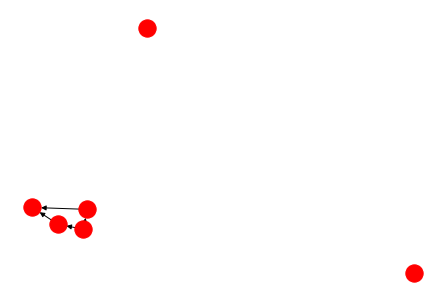

In [8]:
import networkx as nx

g = maxflow.GraphFloat()
nodeids = g.add_grid_nodes((2, 2))
structure = np.array([[0, 0, 0],
                          [0, 0, 1],
                          [0, 1, 0]])
# Or structure = maxflow.vonNeumann_structure(ndim=2, directed=True)
g.add_grid_edges(nodeids, weights=5, structure=structure,
        symmetric=False)
print( g.get_edge_count() )
G = g.get_nx_graph()


nx.draw_spring(G)

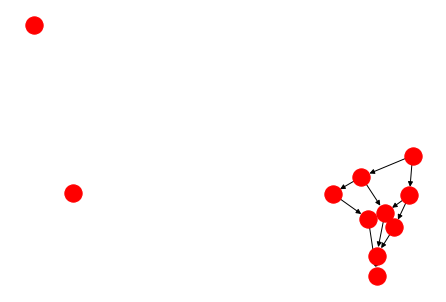

In [9]:
import networkx as nx
g = maxflow.GraphFloat()
nodeids = g.add_grid_nodes((3, 3))
structure = np.array([[0, 0, 0],
                          [0, 0, 1],
                          [0, 1, 0]])
weights = np.array([[1, 2, 3],
                        [4, 5, 6],
                        [7, 8, 9]])
g.add_grid_edges(nodeids, weights=weights, structure=structure,
        symmetric=False)
G = g.get_nx_graph()


nx.draw_spring(G)

In [ ]:
# -*- coding: utf-8 -*-
from numpy import *
import numpy
import maxflow
from PIL import Image
from matplotlib import pyplot as plt
from pylab import *
import cv2

#The function implements graph cut by partitioning a directed graph into two disjoint sets, foreground and background...
#def graph(file, # input image
#        k, # kappa value --> similar pixels have weight close to kappa
#        s, # Sigma value --> determines how fast the values decay towards zero with increasing dissimilarity.
#        fore, # foreground area ---> should be input by the user manually.
#        back): # background area ---> should be input by the user manually.
  
file = '/Users/mxhf/work/src/Graph-Cut/input4.jpg'
k = 20.*2
s = 120
fore = (200,290,220,300)
back = (11,12,80,52)

if True:    
    I = (Image.open(file).convert('L')) # read image
    
    If = I.crop(fore) # take a part of the foreground
    Ib = I.crop(back) # take a part of the background
    I,If,Ib = array(I),array(If),array(Ib) # convert all the images to arrays to calculation
    Ifmean = mean(cv2.calcHist([If],[0],None,[256],[0,256])) #Taking the mean of the histogram
    Ibmean = mean(cv2.calcHist([Ib],[0],None,[256],[0,256])) 
    
    F,B =  ones(shape = I.shape),ones(shape = I.shape) #initalizing the foreground/background probability vector
    
    #Im = I.reshape(-1,1) #Coverting the image array to a vector for ease.
    m,n = I.shape[0],I.shape[1]# copy the size
    g = maxflow.Graph[int](m,n)# define the graph
    pic = maxflow.Graph[int]() 
    structure = np.array([[inf, 0, 0],
                          [inf, 0, 0],
                          [inf, 0, 0]
                         ]) # initializing the structure....
    
    source,sink,J = m*n,m*n+1,I # Defining the Source and Sink (terminal)nodes.
    
    nodes = g.add_nodes(m*n)
    nodeids = pic.add_grid_nodes(J.shape) # Adding non-nodes
    pic.add_grid_edges(nodeids,0),pic.add_grid_tedges(nodeids, J, 255-J)

    print("Foo 1 ....")
    gr = pic.maxflow()
    IOut = pic.get_grid_segments(nodeids)
    #plt.imshow( IOut )
    #1/0
    print("Foo 2 ....")
    F = -log(abs(I - Ifmean)/(abs(I - Ifmean)+abs(I - Ibmean))) # Probability of a pixel being foreground
    B = -log(abs(I - Ibmean)/(abs(I - Ibmean)+abs(I - Ifmean))) # Probability of a pixel being background            
    print("Foo 3 ....")
    F,B = F.reshape(-1,1),B.reshape(-1,1) # convertingb  to column vector for ease
    #print(Im)
    #for i in range(Im.shape[0]):
    #    Im[i] = Im[i] / linalg.norm(Im[i]) # normalizing the input image vector 
    #print(Im)
    w = structure # defining the weight       
    
    print("Foo 4 ....")
    for i in range(m*n):#checking the 4-neighborhood pixels
        
        ws=(F[i]/(F[i]+B[i])) # source weight
        wt=(B[i]/(F[i]+B[i])) # sink weight
        g.add_tedge(i,ws[0],wt) # edges between pixels and terminal
        if i%n != 0: # for left pixels
            w = k*exp(-(abs(Im[i]-Im[i-1])**2)/s) # the cost function for two pixels
            g.add_edge(i,i-1,w[0],k-w[0]) # edges between two pixels
            '''Explaination of the likelihood function: * used Bayes’ theorem for conditional probabilities
            * The function is constructed by multiplying the individual conditional probabilities of a pixel being either 
            foreground or background in order to get the total probability. Then the class with highest probability is selected.
            * for a pixel i in the image:
                               * weight from sink to i:
                               probabilty of i being background/sum of probabilities
                               * weight from source to i:
                               probabilty of i being foreground/sum of probabilities
                               * weight from i to a 4-neighbourhood pixel:
                                 K * e−|Ii−Ij |2 / s
                                 where k and s are parameters that determine hwo close the neighboring pixels are how fast the values
                                 decay towards zero with increasing dissimilarity
            '''
        if (i+1)%n != 0: # for right pixels
            w = k*exp(-(abs(Im[i]-Im[i+1])**2)/s)
            g.add_edge(i,i+1,w[0],k-w[0]) # edges between two pixels
        if i//n != 0: # for top pixels
            w = k*exp(-(abs(Im[i]-Im[i-n])**2)/s)
            g.add_edge(i,i-n,w[0],k-w[0]) # edges between two pixels
        if i//n != m-1: # for bottom pixels
            w = k*exp(-(abs(Im[i]-Im[i+n])**2)/s)
            g.add_edge(i,i+n,w[0],k-w[0]) # edges between two pixels

    print("Foo 5 ....")
    
    print( "g.maxflow()", g.maxflow() )
    IOut2 = g.get_grid_segments(nodeids)
    
    
    #print( "The maximum flow for %s is %d"%(file,g.maxflow()) )# find and print the maxflow
    print( "The maximum flow for %s is %d"%(file,gr) )# find and print the maxflow
    
    plt.imshow( IOut )
    plt.imshow( IOut2 )
#graph('input1.jpg',2,100,(225,142,279,185),(7,120,61,163)) #calling the maxflow funtion for input1
#graph('input2.jpg',20.*2,10*120,(148,105,201,165),(11,12,80,52)) #calling the maxflow funtion for input2



In [ ]:
Im.min()

In [ ]:
plt.imshow( IOut )

In [ ]:
  
if __name__=='__main__':

    parser = argparse.ArgumentParser()
    parser.add_argument("-m", "--minsize", type=int, default=3,
                        help="Minimum region size.")
    parser.add_argument("-g", "--sigma_grow_threshold", type=float,  default=3.,
                        help="Region growth threshold.")
    parser.add_argument("-d","--sigma_detect_threshold", type=float, default=5.,
                        help="Detection threshold.")
    parser.add_argument('-i', '--infile', type=str,                    
                        help='Input cube.')
    parser.add_argument('-o', '--outfile', type=str, default='',
                        help='Output map.')
    parser.add_argument('-b', '--bad_regions', type=str, default='',
                        help='Output map.')

    parser.add_argument('-n', '--noisemodel', type=str, default='',
                        help='File containing the polynomial parameters for the noise model.')

    args = parser.parse_args(sys.argv[1:])

    badwlregions = []

    if args.bad_regions != '':
        if not os.path.exists(args.bad_regions):
            print("WARNING: {} not found proceeding without.".format(args.bad_regions))
        else:
            t = ascii.read(args.bad_regions)
            for r in t:
                badwlregions.append([r["start"],r["end"]])



    fcube = args.infile
    fmapout = args.outfile
    sigma_detect_threshold = args.sigma_detect_threshold
    sigma_grow_threshold = args.sigma_grow_threshold
    minsize = args.minsize

    noise_model = np.loadtxt(args.noisemodel)

    s = spectrum.readSpectrum(fcube)
    ww = s.grid()
    c = s.data
    for r in badwlregions:  
        c[r[0]:r[1]] = 0. # take out bad region

    outmap = build_map(ww, c, sigma_detect_threshold, sigma_grow_threshold, noise_model)
    outmap = filter_minsize(outmap, minsize)


    save_map(outmap, fmapout)